In [1]:
import pandas as pd 
import numpy as np
import os      
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time 
from sklearn.metrics import mean_squared_error
path="/home/nakajo/GT_Kids/Results/ML_data/"

In [2]:
df_KID1_ml=pd.read_pickle("df_KID1_ml.pkl")
df_KID3_ml=pd.read_pickle("df_KID3_ml.pkl")
df_KID7_ml=pd.read_pickle("df_KID7_ml.pkl")
df_KID9_ml=pd.read_pickle("df_KID9_ml.pkl")
df_KID11_ml=pd.read_pickle("df_KID11_ml.pkl")

In [ ]:
df_KID11_ml['CPU_temperature(degC)'].plot()

In [ ]:
df_KID1_ml['CPU_temperature(degC)'].plot()

In [ ]:
df_KID11_ml['KID11_jobs'].plot()

In [ ]:
df_KID11_ml.head()

In [ ]:
corr_mat=df_KID11_ml.corr()
sns.set()
sns.heatmap(corr_mat,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.1f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()

# Regression using neural network

In [3]:
import tensorflow as tf
from sklearn import linear_model, preprocessing, cross_validation, svm
from sklearn.svm import SVR

/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

def MakeInputData(df_KID, KID_NAME):
    input_current_state=df_KID[['CPU_utilization','FAN (%)', 'CPU_temperature(degC)', 'PS']].reset_index()
    input_job=df_KID[KID_NAME+'_jobs'].reset_index()
    Inp_np=np.empty((0, 5), float)
    for i in range(len(df_KID)-1):
        Inp_series=pd.concat([input_current_state.ix[i], input_job.ix[i+1]]).drop('Elapsed time (s)')
        tmp_np=np.array(Inp_series)
        Inp_np=np.append(Inp_np, [tmp_np], axis=0)
    input_data_np=Inp_np
    return input_data_np

def MakeOutputData(df_KID, KID_NAME):
    output_candidates=df_KID[['CPU_temperature(degC)', KID_NAME+'_serve_time']].reset_index()
    Oup_np=np.empty((0,2), float)
    oup_series=output_candidates.drop('Elapsed time (s)', axis=1)
    tmp_np=np.array(oup_series)
    Oup_np=np.append(Oup_np,tmp_np, axis=0)
    output_data_np=Oup_np[1:] # skip the initital state 
    return output_data_np

def DetermineNeuron(nInput, nOutput):
    #非線形回帰モデル
    # 30分類器 full=connection
    global W_fc1, b_fc1, h_fc1, W_fc2, b_fc2, h_fc2, keep_prob, W_fc3, b_fc3, y
    #第１層
    W_fc1 = weight_variable([nInput,30])
    b_fc1 = bias_variable([30])
    h_fc1 = tf.nn.relu(tf.matmul(x,W_fc1) + b_fc1) #発火の定義，発火関数はrelu

    #第２層
    W_fc2 = weight_variable([30,10])
    b_fc2 = bias_variable([10])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1,W_fc2) + b_fc2)

    keep_prob = tf.placeholder(tf.float32)  

    #最終層（OutPut）
    W_fc3 = weight_variable([10,nOutput])
    b_fc3 = bias_variable([nOutput])
    y = tf.nn.relu(tf.matmul(h_fc2,W_fc3) + b_fc3)

def DefinePlaceHolder(nInput, nOutput):
    global x, y_, w, b
    x = tf.placeholder(tf.float32, shape=[None, nInput], name = "input")
    #x = tf.placeholder(tf.float32, shape=[nInput], name = "input")
    y_ = tf.placeholder(tf.float32, shape=[None, nOutput], name = "output") 
    #y_ = tf.placeholder(tf.float32, shape=[nOutput], name = "output") 

    w = tf.Variable(tf.zeros([nInput, nOutput]))  #weight
    b = tf.Variable(tf.zeros([nOutput])) #bias
    
def InitiateModel():
    global sess, cross_entropy, train_step
    #y_ = training data , y = predection data 
    cross_entropy = tf.reduce_mean(tf.reduce_sum(tf.square(y - y_)))
    #train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    #sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer()) # Initialize variables
      
def Batch_NN_model(input_data_np, output_data_np, epoch):
    global losses
    batch_size = 8 # バッチサイズ  
    num_data = 256
    losses=[]
    print(num_data)
    for i in range(epoch):
        for idx in range(0, num_data, batch_size):
            Input_batch = input_data_np[idx:idx+batch_size]
            Output_batch = output_data_np[idx:idx+batch_size]
           # train_step.run(feed_dict={x:Input_batch, y_:Output_batch})
            train_step.run(feed_dict={x:Input_batch, y_:Output_batch, keep_prob:1.0})
        if i%200 == 0:
          #  loss = sess.run(cross_entropy,feed_dict={x:Input, y_:Output})
            loss = sess.run(cross_entropy,feed_dict={x:input_data_np, y_:output_data_np, keep_prob:1.0})
            print("set %d"%(i))
            print("loss ={} ".format(loss))
            losses.append(loss)
    print('end')

def ShowGraph(input_data_np, output_data_np, KID_NAME, epoch):
    #予測値(y)の算出
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    NN_predict=sess.run(y, feed_dict={x:input_data_np, y_: output_data_np})
    plt.plot(NN_predict[256:, 0], label="NN prediction")
    plt.plot(output_data_np[256:, 0], label="Measured data")
    plt.xlabel("Data point (time_scale)")
    plt.ylabel("Temperature (deg C)")
    plt.title("Model_for_"+ KID_NAME)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    Set=[]
    for i in range(200, epoch, 200):
        Set.append(i)
    plt.plot(Set, losses[1:], linestyle="solid", marker="o", label="NN_predict")
    plt.xlabel("epoch") 
    plt.ylabel("loss")
    plt.title('NN_learning_process')
    plt.legend(loc ="upper right")
    plt.show()
    print("MSE:", mean_squared_error(output_data_np, NN_predict))

def Main(df_KID_ml, KID_NAME):
    tf.reset_default_graph()
    nInput=5
    nOutput=2
    epoch=10000
    DefinePlaceHolder(nInput, nOutput)
    DetermineNeuron(nInput, nOutput)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        InitiateModel()
        input_data_np_KID=MakeInputData(df_KID_ml,KID_NAME)
        output_data_np_KID=MakeOutputData(df_KID_ml, KID_NAME)
        start=time.time()
        Batch_NN_model(input_data_np_KID, output_data_np_KID, epoch)
        process_time=time.time()-start
        print("Prediction time:", process_time)
        print("W_fc1 : %s" % W_fc1.eval())
        print("W_fc2 : %s" % W_fc2.eval())
        save_path=saver.save(sess, './'+KID_NAME+'_NN_model.ckpt')
        ShowGraph(input_data_np_KID, output_data_np_KID, KID_NAME, epoch)
        print("Model saved in path: %s" % os.getcwd()+save_path)

# Training

In [5]:
nInput=5
nOutput=2
epoch=10000
DefinePlaceHolder(nInput, nOutput)
DetermineNeuron(nInput, nOutput)
saver = tf.train.Saver()

/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


256
set 0
loss =1316005.75 
set 200
loss =712.3948974609375 
set 400
loss =318.55804443359375 
set 600
loss =303.9460144042969 
set 800
loss =292.9839782714844 
set 1000
loss =284.35491943359375 
set 1200
loss =277.1853942871094 
set 1400
loss =270.851318359375 
set 1600
loss =265.3846740722656 
set 1800
loss =260.64752197265625 
set 2000
loss =256.48406982421875 
set 2200
loss =252.92495727539062 
set 2400
loss =250.29869079589844 
set 2600
loss =248.1348114013672 
set 2800
loss =246.4656219482422 
set 3000
loss =245.1225128173828 
set 3200
loss =243.8899383544922 
set 3400
loss =242.9394073486328 
set 3600
loss =242.0309295654297 
set 3800
loss =241.0673065185547 
set 4000
loss =240.3112030029297 
set 4200
loss =239.81968688964844 
set 4400
loss =239.40533447265625 
set 4600
loss =239.11241149902344 
set 4800
loss =239.01170349121094 
set 5000
loss =239.17515563964844 
set 5200
loss =239.15499877929688 
set 5400
loss =238.9450225830078 
set 5600
loss =238.30979919433594 
set 5800
los

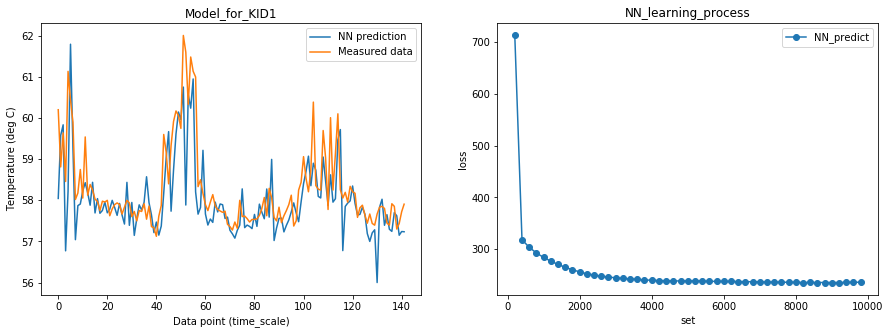

MSE: 0.2964405506069574
Model saved in path: /home/nakajo/GT_Kids/Results/ML_data/data_5_ver1/ml_data./KID1_NN_model.ckpt


In [7]:
with tf.Session() as sess:
    InitiateModel()
    input_data_np_KID1=MakeInputData(df_KID1_ml,"KID1")
    output_data_np_KID1=MakeOutputData(df_KID1_ml, "KID1")
    start=time.time()
    Batch_NN_model(input_data_np_KID1, output_data_np_KID1, epoch)
    process_time=time.time()-start
    print("Prediction time:", process_time)
    print("W_fc1 : %s" % W_fc1.eval())
    #print("W_fc2 : %s" % W_fc2.eval())
    save_path_local=saver.save(sess, './KID1_NN_model.ckpt')
    #save_path_vali=saver.save(sess, '/home/nakajo/GT_Kids/Results/ML_data/vailidation_ver1/ml_data/KID1_NN_model/KID1_NN_model.ckpt')
    ShowGraph(input_data_np_KID1, output_data_np_KID1, "KID1", epoch)
    print("Model saved in path: %s" % os.getcwd()+save_path_local)
    #print("Model saved in path: %s" % os.getcwd()+save_path_vali)

In [ ]:
tf.reset_default_graph()
nInput=5
nOutput=2
epoch=10000
DefinePlaceHolder(nInput, nOutput)
DetermineNeuron(nInput, nOutput)
saver = tf.train.Saver()

In [ ]:
with tf.Session() as sess:
    InitiateModel()
    input_data_np_KID1=MakeInputData(df_KID3_ml,"KID3")
    output_data_np_KID1=MakeOutputData(df_KID3_ml, "KID3")
    start=time.time()
    Batch_NN_model(input_data_np_KID1, output_data_np_KID1, epoch)
    process_time=time.time()-start
    print("Prediction time:", process_time)
    print("W_fc1 : %s" % W_fc1.eval())
    #print("W_fc2 : %s" % W_fc2.eval())
    save_path_local=saver.save(sess, './KID3_NN_model.ckpt')
    #save_path_vali=saver.save(sess, '/home/nakajo/GT_Kids/Results/ML_data/vailidation_ver1/ml_data/KID3_NN_model/KID3_NN_model.ckpt')
    ShowGraph(input_data_np_KID1, output_data_np_KID1, "KID3", epoch)
    print("Model saved in path: %s" % os.getcwd()+save_path_local)
    #print("Model saved in path: %s" % os.getcwd()+save_path_vali)

In [ ]:
tf.reset_default_graph()
nInput=5
nOutput=2
epoch=10000
DefinePlaceHolder(nInput, nOutput)
DetermineNeuron(nInput, nOutput)
saver = tf.train.Saver()

In [ ]:
with tf.Session() as sess:
    InitiateModel()
    input_data_np_KID1=MakeInputData(df_KID7_ml,"KID7")
    output_data_np_KID1=MakeOutputData(df_KID7_ml, "KID7")
    start=time.time()
    Batch_NN_model(input_data_np_KID1, output_data_np_KID1, epoch)
    process_time=time.time()-start
    print("Prediction time:", process_time)
    print("W_fc1 : %s" % W_fc1.eval())
    #print("W_fc2 : %s" % W_fc2.eval())
    save_path_local=saver.save(sess, './KID7_NN_model.ckpt')
    #save_path_vali=saver.save(sess, '/home/nakajo/GT_Kids/Results/ML_data/vailidation_ver1/ml_data/KID7_NN_model/KID7_NN_model.ckpt')
    ShowGraph(input_data_np_KID1, output_data_np_KID1, "KID7", epoch)
    print("Model saved in path: %s" % os.getcwd()+save_path_local)
    #print("Model saved in path: %s" % os.getcwd()+save_path_vali)

In [ ]:
tf.reset_default_graph()
nInput=5
nOutput=2
epoch=10000
DefinePlaceHolder(nInput, nOutput)
DetermineNeuron(nInput, nOutput)
saver = tf.train.Saver()

In [ ]:
with tf.Session() as sess:
    InitiateModel()
    input_data_np_KID1=MakeInputData(df_KID9_ml,"KID9")
    output_data_np_KID1=MakeOutputData(df_KID9_ml, "KID9")
    start=time.time()
    Batch_NN_model(input_data_np_KID1, output_data_np_KID1, epoch)
    process_time=time.time()-start
    print("Prediction time:", process_time)
    print("W_fc1 : %s" % W_fc1.eval())
    #print("W_fc2 : %s" % W_fc2.eval())
    save_path_local=saver.save(sess, './KID9_NN_model.ckpt')
    #save_path_vali=saver.save(sess, '/home/nakajo/GT_Kids/Results/ML_data/vailidation_ver1/ml_data/KID9_NN_model/KID9_NN_model.ckpt')
    ShowGraph(input_data_np_KID1, output_data_np_KID1, "KID9", epoch)
    print("Model saved in path: %s" % os.getcwd()+save_path_local)
    #print("Model saved in path: %s" % os.getcwd()+save_path_vali)

In [ ]:
tf.reset_default_graph()
nInput=5
nOutput=2
epoch=10000
DefinePlaceHolder(nInput, nOutput)
DetermineNeuron(nInput, nOutput)
saver = tf.train.Saver()

In [ ]:
with tf.Session() as sess:
    InitiateModel()
    input_data_np_KID1=MakeInputData(df_KID11_ml,"KID11")
    output_data_np_KID1=MakeOutputData(df_KID11_ml, "KID11")
    start=time.time()
    Batch_NN_model(input_data_np_KID1, output_data_np_KID1, epoch)
    process_time=time.time()-start
    print("Prediction time:", process_time)
    print("W_fc1 : %s" % W_fc1.eval())
    #print("W_fc2 : %s" % W_fc2.eval())
    save_path_local=saver.save(sess, './KID11_NN_model.ckpt')
    #save_path_vali=saver.save(sess, '/home/nakajo/GT_Kids/Results/ML_data/vailidation_ver1/ml_data/KID11_NN_model/KID11_NN_model.ckpt')
    ShowGraph(input_data_np_KID1, output_data_np_KID1, "KID11", epoch)
    print("Model saved in path: %s" % os.getcwd()+save_path_local)
    #print("Model saved in path: %s" % os.getcwd()+save_path_vali)

In [13]:
input_data_np_KID1

array([[ 0.2675    , 27.83      , 53.29861111,  9.23333333, 20.        ],
       [ 0.68      , 27.83      , 53.80555556,  8.56666667, 15.        ],
       [ 0.68      , 27.83      , 53.13888889,  6.6       , 25.        ],
       ...,
       [ 0.79      , 27.83      , 57.30208333,  6.00654762, 15.        ],
       [ 0.79      , 27.83      , 57.4375    ,  7.24444444, 15.        ],
       [ 0.775     , 27.83      , 57.72222222,  6.21666667, 10.        ]])

In [14]:
df_KID1_ml.head()

,CPU_temperature(degC),CPU_utilization,FAN (%),KID1_jobs,KID1_serve_time,PS
Elapsed time (s),,,,,,
21,53.298611,0.2675,27.83,20.0,0.195377,9.233333
23,53.805556,0.6800,27.83,20.0,0.211183,8.566667
25,53.138889,0.6800,27.83,15.0,0.153194,6.600000
28,53.895833,0.6200,27.83,25.0,0.265763,12.135714
29,54.000000,0.6200,27.83,20.0,0.213699,11.985714
